In [1]:
import pandas as pd
import scanpy as sc
import glob
import numpy as np
import seaborn as sns; 
import matplotlib.pyplot as plt
import scipy as sp

<div class="alert alert-info">

**Note**
    
This notebook provides analysis on the critical gene analysis. Require input are: csv file which is a matrix
    
</div>  

# Define parameters

In [2]:
# Different dataset have diffrerent column name to store the celltype
def get_ct(data): 
    if(data=="GSE110894"):
        return("Sample name")
    elif(data=="GSE117872_HN120"):
        return("cell_color")
    elif(data=="GSE117872_HN137"):
        return("cell_color")
    else:
        return("sensitivity")

In [3]:
# Select DATA case as GSE117872
# The critical gene will be orderd by log fold change
DATA = "GSE117872_HN120"
PCT_EXP = 25
ORDER = 'log_fc'
sc.settings.set_figure_params(dpi=100, facecolor='white')

# Read critical gene names

The input of this step is a txt matrix file of the Captum calculated integrated gradients. Will be generated if we applied --printgene 'T' in the scmodel.py script. "sc_gradient.txt"

In [4]:
# Change it to your path that save h5ad for HN120 critical gene gradient
f_cg = glob.glob("data/*"+DATA+"sc_gradient.txt")
df_cg = pd.read_csv(f_cg[0],sep=" ",header=None)

In [5]:
# Change it to your path that save h5ad for HN120 critical gene name
f_gn = glob.glob("data/*"+DATA+"sc_gene.csv")
df_gene = pd.read_csv(f_gn[0],index_col=0)

In [6]:
df_cg.columns = df_gene.iloc[:,0].values

# Read result h5ad files

In [7]:
# Change it to your path that saved h5ad for the case study
adata_fname = glob.glob("saved/adata/*"+DATA+"*h5ad")

In [8]:
adata = sc.read_h5ad(adata_fname[0])

The metadata feil is shown as follows

In [9]:
adata.obs.head()

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,sensitivity,...,pct_counts_rps,total_counts_rpl,pct_counts_rpl,leiden,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,sens_label,rest_preds
RHH2177,HN120P,cyan,HN120,Primary,Sensitive,4,2,3,1,Sensitive,...,5.728728,89409.546875,8.941137,3,3,2.725659e-02,0,1.000000,1,3.950997e-07
RHH2178,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,6.369886,93044.312500,9.304440,3,3,5.752981e-01,1,0.999999,1,9.452011e-07
RHH2179,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,5.890006,94809.320312,9.481583,3,3,9.238300e-08,0,0.999999,1,1.008827e-06
RHH2180,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,5.437080,85402.531250,8.540504,3,3,5.741795e-08,0,1.000000,1,1.374240e-07
RHH2181,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,5.040665,82698.773438,8.269890,3,3,1.635570e-05,0,0.999999,1,8.696580e-07


# Read result h5ad files

We organize different comparison groups stored in a map. Each group are selected subsets of the dataset. We will compare one versus rest comparisons with each other

In [10]:
map_ref_group = {
    1: ["HN120P",'HN120PCR'],
    2: ['HN120P',"HN120M"],
    3: ['HN120PCR','HN120MCR'],
    4: ['HN120P','HN120PCRDH','HN120PCR'],
    5: ['HN120M','HN120MCRDH','HN120MCR'],
}

In [11]:
df_cg.index = adata.obs.index

Propsessing the critical gene matrix

In [12]:
df_cg = abs(df_cg)
igadata= sc.AnnData(df_cg)
igadata.var.index = adata.var.index
igadata.obs.index = adata.obs.index
igadata.obs=adata.obs
igadata.obs['sens_label'] = adata.obs['sens_label'].astype('category')

In [13]:
sc.pp.filter_cells(igadata, min_genes=200)
sc.pp.filter_genes(igadata, min_cells=3)
#sc.pl.highest_expr_genes(igadata, n_top=20, )
sc.pp.normalize_total(igadata)
sc.pp.log1p(igadata)
sc.pp.highly_variable_genes(igadata, min_mean=0.0125, max_mean=3, min_disp=0.5)
igadata.obs['sens_label'] = adata.obs['sens_label'].astype('category')
rg_result = sc.tl.rank_genes_groups(igadata, 'sens_label',method='wilcoxon',pts=True)

Preview meta of the integrated gradient matrix

In [14]:
igadata.obs

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,sensitivity,...,pct_counts_rps,total_counts_rpl,pct_counts_rpl,leiden,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,sens_label,rest_preds
RHH2177,HN120P,cyan,HN120,Primary,Sensitive,4,2,3,1,Sensitive,...,5.728728,89409.546875,8.941137,3,3,2.725659e-02,0,1.000000,1,3.950997e-07
RHH2178,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,6.369886,93044.312500,9.304440,3,3,5.752981e-01,1,0.999999,1,9.452011e-07
RHH2179,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,5.890006,94809.320312,9.481583,3,3,9.238300e-08,0,0.999999,1,1.008827e-06
RHH2180,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,5.437080,85402.531250,8.540504,3,3,5.741795e-08,0,1.000000,1,1.374240e-07
RHH2181,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,5.040665,82698.773438,8.269890,3,3,1.635570e-05,0,0.999999,1,8.696580e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHH3196,HN120MCRDH,goldenrod1,HN120,Metastatic,Holiday,3,1,5,1,Sensitive,...,7.195270,111342.632812,11.134289,1,1,9.999752e-01,1,0.999991,1,7.955970e-06
RHH3197,HN120MCRDH,goldenrod1,HN120,Metastatic,Holiday,3,1,5,1,Sensitive,...,9.895282,133713.531250,13.371383,1,1,9.991913e-01,1,0.999995,1,4.468856e-06
RHH3200,HN120MCRDH,goldenrod1,HN120,Metastatic,Holiday,3,1,5,1,Sensitive,...,9.030272,124313.585938,12.434580,1,1,9.999864e-01,1,0.999999,1,9.671833e-07
RHH3203,HN120MCRDH,goldenrod1,HN120,Metastatic,Holiday,3,1,5,1,Sensitive,...,8.852252,127109.421875,12.711032,1,1,9.999262e-01,1,0.999999,1,4.565799e-07


# Perform wilcoxon tests on integrated gradient values among clusters

Trying to set attribute `.uns` of view, copying.


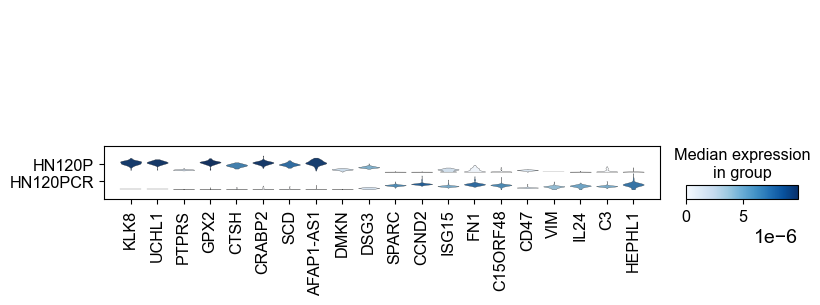

Trying to set attribute `.uns` of view, copying.


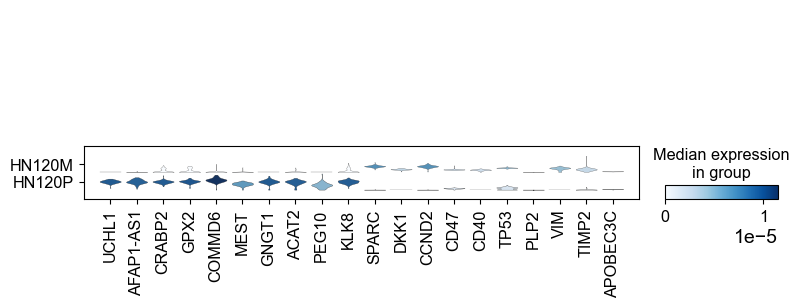

Trying to set attribute `.uns` of view, copying.


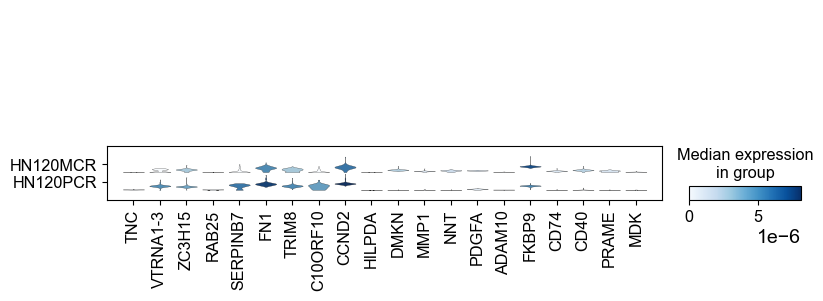

Trying to set attribute `.uns` of view, copying.


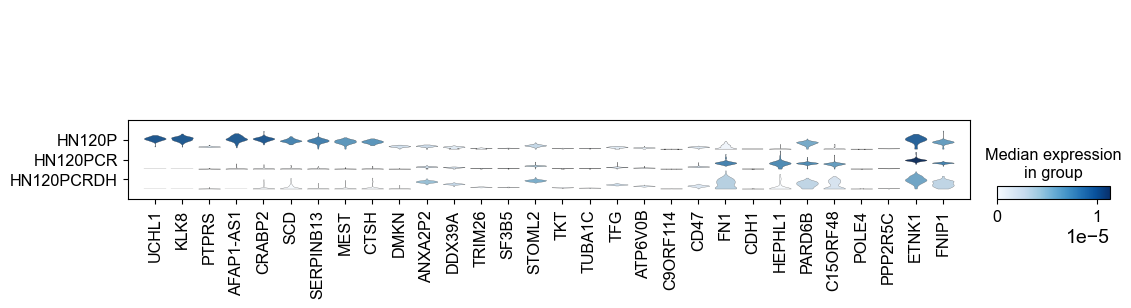

Trying to set attribute `.uns` of view, copying.


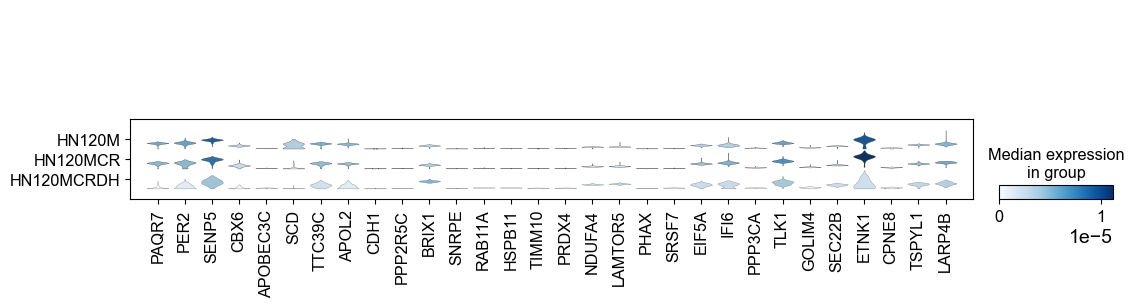

In [15]:
# Save the gene tables into csv files
for i in range(1,6):
    subset_igdata = igadata[igadata.obs['cell_color'].isin(map_ref_group[i])]
    rg_result = sc.tl.rank_genes_groups(subset_igdata, 'cell_color', groups=map_ref_group[i], reference='rest', method='wilcoxon',pts =True)
    #sc.pl.rank_genes_groups(subset_igdata, groups=map_ref_group[i], n_genes=20,save="critical_genes_rank_"+str(clip)+str(i)+".svg")
    df_name = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['names'])#.to_csv("critical_genes_experiment_"+str(i)+".csv")
    df_lgfc = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['logfoldchanges'])#.to_csv("critical_logfc_experiment_"+str(i)+".csv")
    df_pval = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['pvals_adj'])#.to_csv("critical_genes_experiment_"+str(i)+".csv")
    df_pts = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['pts'])#.to_csv("critical_logfc_experiment_"+str(i)+".csv")

    for c in df_name.columns:
        tmp_df = pd.DataFrame({"gene_name":df_name[c],"log_fc":df_lgfc[c],'pvals_adj':df_pval[c],'pts':df_pts.loc[df_name[c].values,c].values})
        tmp_df.to_csv("critical_genes_experiment_"+str(i)+"_type_"+str(c)+"_vs_others.csv")

    sc.pl.stacked_violin(subset_igdata, pd.DataFrame(subset_igdata.uns['rank_genes_groups']['names']).head(10).T.values.ravel(), groupby='cell_color',\
                        rotation=180,save="critical_genes_violint_"+str(i)+".svg"
                        );

# Filter critical gens by logfc val and percentages

In [16]:
gene = pd.read_csv("critical_genes_experiment_1_type_HN120P_vs_others.csv")
gene = gene[gene['log_fc'].abs()>0.1]
gene = gene[gene['pvals_adj']<=0.05]
gene = gene[gene['pts']>0.2]
gene=gene.sort_values("log_fc",ascending=True)
res = list(gene[gene['log_fc']<0]['gene_name'])
gene=gene.sort_values("log_fc",ascending=False)
sen=list(gene[gene['log_fc']>0]['gene_name'])

Print head sensitive critical genes and resistant genes

In [17]:
print(res[:10])

['CDH1', 'ZSCAN25', 'ZXDC', 'CNOT11', 'CDPF1', 'AKAP12', 'C3', 'ANGPTL4', 'POLE4', 'ARHGDIB']


In [18]:
print(sen[:10])

['UCHL1', 'GNGT1', 'KLK8', 'EDIL3', 'C16ORF54', 'SLC7A8', 'SESN3', 'ACKR3', 'LINC00162', 'NEFL']
